Alunos: Daniel de Paula, Gustavo Guerreiro e Mayara Cardoso Simões

# Trabalho Final de Aprendizado de Máquina sobre Visão Computacional: Classificação de Imagens de Cães e Gatos

O dataset utilizado é de propriedade da Microsoft e está disponível em: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset

## Separação dos Dados em Treino, Teste e Validação

A primeira etapa da implementação é a de separação dos dados. Inicialmente o diretório se encontra no formato:
```
PetImages/
├── Cat
└── Dog
```

Como uma Rede Neural necessita de uma separação entre treino, teste e possivelmente validação, o GeneratorBasedBuilder irá carregar os dados logicamente com a seguinte estrutura:
```
dataset/
├── train/
│   ├── Cat/
│   └── Dog/
├── val/
│   ├── Cat/
│   └── Dog/
└── test/
    ├── Cat/
    └── Dog/
```
Para usar essa estrutura se utilizou a classe GeneratorBasedBuilder do TensorFlow para fazer a divisão mais eficiente e monstar a estrutura em treino, validação e teste.

## Importação das bibliotecas

In [94]:
import gc
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
from PIL import Image
from glob import glob
from random import Random
from os import path, remove
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras import layers, models, mixed_precision, Model
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow_datasets.core import GeneratorBasedBuilder, DatasetInfo, Version
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## Configuração para uso da GPU

In [95]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Detectada e Configurada: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("Nenhuma GPU detectada.")

GPU Detectada e Configurada: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Ativação de Mixed Precision

In [96]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print(f"Política de computação: {policy.compute_dtype}")
print(f"Política de variáveis: {policy.variable_dtype}")

Política de computação: float16
Política de variáveis: float32


## Definição da Classe do Dataset

Para organizar o dataset de uma forma mais eficiente foi criada a classe CatsDogs.
Inicialmente se tem uma função auxiliar chamada listar_imagens_validas, ela é usada para checar se a imagem sendo tratada é de fato um jpg válido ou foi corrompido.

Já a classe CatsDogs em si possui três métodos:
* _info: contém as informações contidas no dataset, no caso uma imagem de 3 dimensões (altura, largura e cor RGB) e o rótulo podendo ser "Cat" ou Dog.
* _split_generators: método principal que busca nas pastas as imagens dos gatos e cães, separa cada grupo em treino, validação e teste e então junta as imagens de cada animal.
* _generate_examples: usado para gerar os dados retornados em si, pegando cada imagem e atribuindo um id para ela.

In [97]:
def listar_imagens_validas(pasta, label):
    caminhos = glob(f"{pasta}/*")
    validos = []
    reparados = 0
    removidos = 0

    print(f"Sanitizando imagens em: {path.basename(pasta)}... (Isso pode demorar)")

    for caminho in caminhos:
        try:
            if path.getsize(caminho) == 0:
                remove(caminho)
                removidos += 1
                continue

            try:
                with Image.open(caminho) as img:
                    img.load()

                    if img.mode != "RGB":
                        img = img.convert("RGB")

                    img.save(caminho, "JPEG", quality=95)
                    reparados += 1

            except Exception:
                print(f"Deletando arquivo irrecuperável: {os.path.basename(caminho)}")
                remove(caminho)
                removidos += 1
                continue

            validos.append((caminho, label))

        except Exception as e:
            print(f"Erro sistêmico em {caminho}: {e}")
            continue

    print(f"Concluído: {len(validos)} válidos. ({reparados} limpos/reescritos, {removidos} deletados)")
    return validos

class CatsDogs(GeneratorBasedBuilder):
    VERSION = Version("1.0.6")
    SEED = 42
    PASTA_PADRAO = "PetImages"

    def _info(self):
        return DatasetInfo(
            builder=self,
            features=tfds.features.FeaturesDict({
                "image": tfds.features.Image(shape=(None, None, 3)),
                "label": tfds.features.ClassLabel(names=["Cat", "Dog"])
            })
        )

    def _split_generators(self, dl_manager):
        raiz = self.PASTA_PADRAO

        gatos = listar_imagens_validas(f"{raiz}/Cat", 0)
        caes = listar_imagens_validas(f"{raiz}/Dog", 1)

        gatos_treino, gatos_resto = train_test_split(gatos, test_size=0.3, random_state=self.SEED)
        gatos_val, gatos_test = train_test_split(gatos_resto, test_size=0.5, random_state=self.SEED)

        caes_treino, caes_resto = train_test_split(caes, test_size=0.3, random_state=self.SEED)
        caes_val, caes_test = train_test_split(caes_resto, test_size=0.5, random_state=self.SEED)

        rng = Random(self.SEED)
        treino = gatos_treino + caes_treino
        rng.shuffle(treino)

        val = gatos_val + caes_val
        rng.shuffle(val)

        teste = gatos_test + caes_test
        rng.shuffle(teste)

        return {
            "train": self._generate_examples(treino),
            "val": self._generate_examples(val),
            "test": self._generate_examples(teste)
        }

    def _generate_examples(self, arquivos):
        for caminho, rotulo in arquivos:
            if not path.isfile(caminho):
                continue
            yield caminho, {
                "image": caminho,
                "label": rotulo
            }

## Instanciamento dos Datasets
A classe CatsDogs é instanciada e os datasets são construídos, baixados e carregados em variáveis.

In [98]:
builder = CatsDogs()
builder.download_and_prepare()

ds_train = builder.as_dataset(split="train")
ds_val = builder.as_dataset(split="val")
ds_test = builder.as_dataset(split="test")

## Pré-Processamento
As imagens são pré processadas, tendo inicialmente o seu tamanho ajustado e então os seus valores normalizados do formato RGB ($[0, 255]$, $[0, 255]$, $[0, 255]$) para o formato padrão esperado pelo MobileNetV3.

In [99]:
TAMANHO = 224

def preprocessamento(dicionario):
    image = dicionario["image"]
    image = tf.image.resize(image, (TAMANHO, TAMANHO))
    image = tf.cast(image, tf.uint8)
    return image, dicionario["label"]

Além de aplicar o pré-processamento, os dados são organizados para serem divididos em batches para facilitar o processamento na rede e o prefetch para agilizar o processo de carregamento dos batches enquanto a rede é treinada.

In [100]:
BATCH = 64
options = tf.data.Options()
options.autotune.ram_budget = 1024 * 1024 * 1024
options.autotune.enabled = True

def criar_pipeline(ds, treino=True):
    ds = ds.with_options(options)
    ds = ds.map(preprocessamento, num_parallel_calls=4)
    if treino:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

ds_train = criar_pipeline(ds_train)
ds_val = criar_pipeline(ds_val, treino=False)
ds_test = criar_pipeline(ds_test, treino=False)

## Construção do Modelo
Utilizando a arquitetura da rede neural MobileNetV3, congelamos o conhecimento da rede e aplicamos na construção do nosso modelo o chamando de backbone pois trata-se do processamento principal na rede convolucional.

In [101]:
backbone = tf.keras.applications.MobileNetV3Large(
    input_shape=(TAMANHO, TAMANHO, 3),
    include_top=False,
    weights='imagenet'
)

backbone.trainable = False

O data augmentation é configurado de modo a realizar as seguintes operações:
* Inverter as imagens horizontalmente.
* Rotacionar a imagem levemente.
* Aplicar um pequeno zoom na imagem.

In [102]:
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1)
    ],
    name="data_augmentation",
)

Construção do modelo em si, usando uma forma sequencial seguindo as seguintes etapas:
* Definição da camada de input, recebendo uma imagem de tamanho (224,224,3). A última dimensão sendo a das cores.
* Aplicação do data augmentation.
* Aplicação das camadas do backbone da MobileNetV3.
* Achatamento dos resultados com o GlobalAveragePooling2D.
* Aplica um dropout de 40% para evitar overfitting.
* Finalmente tudo se junto na últica camada com um neurônio sigmoid que terá uma valor de 0 a 1. Sendo que se for > 0.5 será considerado cachorro, senão, gato.

In [103]:
def construir_modelo():
    inputs = layers.Input(shape=(TAMANHO, TAMANHO, 3), dtype="uint8")
    x = layers.Rescaling(scale=1.0)(inputs)
    x = preprocess_input(x)
    x = data_augmentation(x)
    x = backbone(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    modelo = Model(inputs=inputs, outputs=outputs)

    return modelo

## Treinamento

Para que o treino não dure mais do que o necessário, e não se use mais épocas do que preciso, criou-se uma função para obter um early stopping, desse forma a partir do momento que a métrica de val_loss não avança por muitas épocas, o treinamento é sumariamente interrompido.

In [104]:
def obter_early_stopping(paciencia):
    return EarlyStopping(
        monitor='val_loss',
        patience=paciencia,
        verbose=1,
        restore_best_weights=True
    )

O modelo é inicialmente treinado, esse treino inicial tem como objetivo treinar apenas o novo cabeçalho (as camadas Dense e Dropout), enquanto o backbone (MobileNetV3) permanece congelado..

In [105]:
tf.keras.backend.clear_session()
gc.collect()

modelo = construir_modelo()

modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

historico = modelo.fit(
    ds_train,
    validation_data=ds_val,
    epochs=25,
    callbacks=[obter_early_stopping(3)],
)
epochs_fase_1 = len(historico.history['loss'])

Epoch 1/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.8985 - loss: 0.2415 - val_accuracy: 0.9837 - val_loss: 0.0488
Epoch 2/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9633 - loss: 0.1007 - val_accuracy: 0.9864 - val_loss: 0.0376
Epoch 3/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.9679 - loss: 0.0894 - val_accuracy: 0.9872 - val_loss: 0.0342
Epoch 4/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.9671 - loss: 0.0857 - val_accuracy: 0.9872 - val_loss: 0.0331
Epoch 5/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.9686 - loss: 0.0807 - val_accuracy: 0.9885 - val_loss: 0.0319
Epoch 6/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.9704 - loss: 0.0796 - val_accuracy: 0.9883 - val_loss: 0.0310
Epoch 7/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.9705 - loss: 0.0769 - val_accuracy: 0.9883 - val_loss: 0.0311
Epoch 8/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.9719 - loss: 0.0787 - 

Em uma segunda etapa, as camadas finais (ou do topo) do backbone são descongeladas e inseridas no treino, dessa forma aprimorando os pesos após a extração inicial das características.

In [106]:
blocos_para_treinar = [f"expanded_conv_{i}" for i in range(7, 15)] + ["conv_1"]

camadas_treinaveis = 0
camadas_congeladas = 0

for layer in backbone.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
        camadas_congeladas += 1
    elif any(bloco in layer.name for bloco in blocos_para_treinar):
        layer.trainable = True
        camadas_treinaveis += 1
    else:
        layer.trainable = False
        camadas_congeladas += 1

print(f"Configuração concluída!")
print(f"Camadas treináveis: {camadas_treinaveis}")
print(f"Camadas congeladas (incluindo BN): {camadas_congeladas}")

Configuração concluída!
Camadas treináveis: 64
Camadas congeladas (incluindo BN): 123


Após o descongelamento das camadas, o treinamento continua a partir da última época do treinamento de extração de características.

In [107]:
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    filepath="melhor_modelo_mobilenetv3.keras",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, patience=3,
    min_lr=1e-8,
    verbose=1
)

historico_fine_tune = modelo.fit(
    ds_train,
    validation_data=ds_val,
    epochs=200,
    initial_epoch=epochs_fase_1,
    callbacks=[obter_early_stopping(20), lr_scheduler, checkpoint]
)

Epoch 10/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9756 - loss: 0.0707
Epoch 10: val_loss improved from None to 0.02615, saving model to melhor_modelo_mobilenetv3.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 53s 151ms/step - accuracy: 0.9772 - loss: 0.0633 - val_accuracy: 0.9893 - val_loss: 0.0262 - learning_rate: 1.0000e-05
Epoch 11/200
273/274 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9790 - loss: 0.0562
Epoch 11: val_loss improved from 0.02615 to 0.02541, saving model to melhor_modelo_mobilenetv3.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - accuracy: 0.9812 - loss: 0.0509 - val_accuracy: 0.9891 - val_loss: 0.0254 - learning_rate: 1.0000e-05
Epoch 12/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9840 - loss: 0.0457
Epoch 12: val_loss improved from 0.02541 to 0.02459, saving model to melhor_modelo_mobilenetv3.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - accuracy: 0.9847 - loss: 0.0420 - val_accuracy: 0.9893 - val_loss: 0.0246 - learning_rat

## Avaliando Modelo

Nesta etapa utiliza-se o Scikit Learn para calcular a acurácia e os outros valores de precisão.

Iniciando avaliação segura...


2025-11-19 12:24:17.836761: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step

--- Relatório de Classificação ---
              precision    recall  f1-score   support

        Gato       1.00      0.99      0.99      1874
         Cão       0.99      1.00      0.99      1874

    accuracy                           0.99      3748
   macro avg       0.99      0.99      0.99      3748
weighted avg       0.99      0.99      0.99      3748

Acurácia: 0.9939


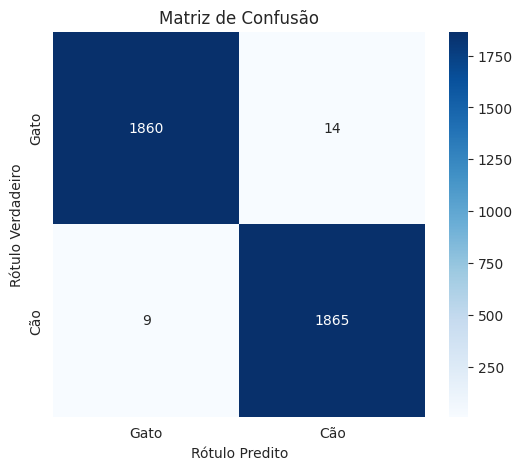

In [110]:
print("Iniciando avaliação...")

y_true = np.concatenate([y for x, y in ds_test], axis=0)

predictions = modelo.predict(ds_test, verbose=1)

y_pred = (predictions > 0.5).astype(int)

target_names = ["Gato", "Cão"]
print("\n--- Relatório de Classificação ---")
print(classification_report(y_true, y_pred, target_names=target_names))
print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

## Salvando o Modelo

O modelo gerado é salvo em um arquivo na mesma pasta do código fonte.

In [109]:
ARQUIVO_MODELO = ('cats_dogs_model_v3.keras')

modelo.save(ARQUIVO_MODELO)